# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Evaluation & Conclusion — Dialogue Summarization with Transformer Models
### Synthesizing Results Across Three Experiments
---

This notebook consolidates findings from the entire project: the exploratory data analysis and three modeling experiments. The goal is not simply to declare a "winner" but to provide a framework for making informed decisions about dialogue summarization based on specific operational constraints.

**What We Set Out to Do**

Modern messaging platforms generate an overwhelming volume of conversations. Users—whether employees catching up on Slack threads or support agents reviewing customer interactions—spend significant time reconstructing what happened in long chat histories. The question we explored: *Can transformer models automatically generate useful summaries of these conversations?*

**How We Approached It**

We evaluated three fundamentally different approaches on the SAMSum dataset (16,368 messenger-style dialogues with human-written summaries):

1. **Experiment 1:** A custom encoder-decoder architecture combining DistilBERT (encoder) with DistilGPT-2 (decoder)—satisfying the assignment requirement for a BERT-family encoder with an autoregressive decoder

2. **Experiment 2:** Purpose-built sequence-to-sequence models (BART and T5) that were pretrained specifically for generation tasks

3. **Experiment 3:** Zero-shot inference using frontier LLMs (GPT-5 Mini, Gemini 2.5 Flash, Claude 4.5 Haiku, Qwen 2.5 72B, Kimi K2) via API

**What This Notebook Covers**

1. Connecting EDA insights to modeling outcomes
2. Consolidated metrics across all models
3. Trade-off analysis for realistic deployment scenarios
4. Honest assessment of what worked and what didn't
5. Actionable recommendations
6. Limitations and future work

The analysis is grounded in ROUGE metrics and latency measurements, but we also discuss what these numbers miss and why qualitative judgment still matters.

## 1. Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Project paths
PROJECT_ROOT = Path("..").resolve()
MODELS_DIR = PROJECT_ROOT / "models"

# Matplotlib style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print(f"Project root: {PROJECT_ROOT}")
print(f"Models directory: {MODELS_DIR}")

Project root: /home/timnevits/projects/flatiron-language-models-for-ai
Models directory: /home/timnevits/projects/flatiron-language-models-for-ai/models


## 2. What the Data Told Us — EDA Synthesis

Before diving into model comparisons, it's worth recalling what we learned about the SAMSum dataset. These characteristics directly influenced how different models performed.

### Dataset Structure

SAMSum contains 16,368 messenger-style conversations with human-written summaries, split into train (14,731), validation (818), and test (819) sets. The splits are statistically similar, which means our cross-experiment comparisons are fair—no model was advantaged or disadvantaged by distribution shift.

In [2]:
# Key dataset statistics from EDA
eda_stats = pd.DataFrame({
    'Metric': ['Dialogue words (median)', 'Summary words (median)', 
               'Compression ratio (median)', 'Turns per dialogue (median)',
               'Speakers per dialogue (median)'],
    'Train': [73, 18, '25.6%', 10, 2],
    'Validation': [70, 18, '26.7%', 9, 2],
    'Test': [74, 18, '25.0%', 10, 2]
})

print("SAMSum Dataset Characteristics")
print("=" * 60)
display(eda_stats)

SAMSum Dataset Characteristics


,Metric,Train,Validation,Test
0,Dialogue words (median),73,70,74
1,Summary words (median),18,18,18
2,Compression ratio (median),25.6%,26.7%,25.0%
3,Turns per dialogue (median),10,9,10
4,Speakers per dialogue (median),2,2,2


### Why This Matters for Modeling

Three EDA findings directly explain the model results we'll see:

**1. High compression ratio (~75% reduction)**

Summaries aren't just shorter versions of dialogues—they're highly compressed. A 73-word dialogue becomes an 18-word summary. This isn't extractive summarization (pulling sentences verbatim); it requires genuine abstraction. Models must identify what's essential and discard the rest.

**2. Style transformation requirement**

The n-gram analysis revealed a fundamental shift between dialogues and summaries:

- **Dialogues:** First/second person, question-heavy, informal ("are you", "do you", "I'll be there")
- **Summaries:** Third person, declarative, formal ("they will meet", "she wants to", "he agreed")

This isn't just compression—it's a register shift. The model must learn to speak *about* the conversation, not *as* the participants. This explains why:
- The Frankenstein model struggled (no pretrained abstraction ability)
- BART excelled (denoising pretraining teaches style transformation)
- API models are fluent but verbose (optimized for helpfulness, not SAMSum's terse style)

**3. Mostly two-person conversations**

With a median of 2 speakers per dialogue, SAMSum is simpler than many real-world scenarios (group chats, team channels). Models that work well here might struggle with more complex multi-party attribution. This is a limitation we'll revisit.

## 3. Consolidated Results

### 3.1 Understanding ROUGE Metrics

Before presenting results, it's important to understand what ROUGE measures—and what it doesn't.

**What ROUGE Is**

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) measures n-gram overlap between generated summaries and human references:

- **ROUGE-1:** Unigram overlap (individual words)
- **ROUGE-2:** Bigram overlap (two-word sequences)
- **ROUGE-L:** Longest common subsequence (captures sentence-level structure)

Higher scores mean more overlap with the reference summary. Scores are reported as percentages (0-100).

**Why We Use ROUGE-L as the Primary Metric**

ROUGE-L is generally preferred for summarization because:
- It captures word ordering, not just bag-of-words overlap
- It's less sensitive to minor paraphrasing than exact n-gram matches
- It correlates reasonably well with human judgments of summary quality

**What ROUGE Misses**

ROUGE has well-known limitations:
- **Synonyms are penalized:** "purchased" vs. "bought" counts as a mismatch
- **Verbose summaries are penalized:** Adding correct information lowers precision
- **Factual errors aren't detected:** A hallucinated but lexically similar summary can score well
- **Style preferences aren't captured:** A different-but-equally-good summary may score poorly

We'll see concrete examples of these limitations when comparing API models to fine-tuned models.

**Our ROUGE Configuration**

All experiments used identical ROUGE settings via the HuggingFace `evaluate` library:
- `use_stemmer=True` (Porter stemmer for fair word matching)
- Evaluated on the same 819 test examples
- Scores reported as percentages for readability

### 3.2 Loading Results from All Experiments

In [3]:
# Load test results from each experiment
def load_test_results(path, model_type):
    """Load test results and add model type column."""
    df = pd.read_csv(path)
    df['type'] = model_type
    return df

# Experiment 1: DistilBERT → DistilGPT2
exp1_results = load_test_results(
    MODELS_DIR / "bert-gpt2-distil" / "test_results.csv",
    "Fine-tuned local"
)

# Experiment 2: BART and T5
bart_results = load_test_results(
    MODELS_DIR / "bart" / "test_results.csv",
    "Fine-tuned local"
)
t5_results = load_test_results(
    MODELS_DIR / "t5" / "test_results.csv",
    "Fine-tuned local"
)

# Experiment 3: API models
api_results = pd.read_csv(MODELS_DIR / "api-frontier" / "test_results.csv")
api_results['type'] = 'Zero-shot API'

# Combine all results
all_results = pd.concat([
    exp1_results,
    bart_results,
    t5_results,
    api_results
], ignore_index=True)

# Sort by ROUGE-L descending
all_results = all_results.sort_values('rougeL', ascending=False).reset_index(drop=True)

print(f"Loaded results for {len(all_results)} models")

Loaded results for 8 models


### 3.3 ROUGE Metrics Comparison

In [4]:
# Create formatted ROUGE comparison table
rouge_table = all_results[['model', 'type', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum']].copy()
rouge_table.columns = ['Model', 'Type', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum']

print("="*80)
print("ROUGE SCORES — ALL MODELS (sorted by ROUGE-L)")
print("="*80)
print()
display(rouge_table)

# Calculate key comparisons
best_finetuned = rouge_table[rouge_table['Type'] == 'Fine-tuned local']['ROUGE-L'].max()
best_api = rouge_table[rouge_table['Type'] == 'Zero-shot API']['ROUGE-L'].max()
gap = best_finetuned - best_api

print(f"\nKey Finding:")
print(f"  Best fine-tuned model (BART): {best_finetuned:.2f} ROUGE-L")
print(f"  Best zero-shot API model (Gemini 2.5 Flash): {best_api:.2f} ROUGE-L")
print(f"  Gap: {gap:.2f} points ({gap/best_api*100:.1f}% relative improvement)")

ROUGE SCORES — ALL MODELS (sorted by ROUGE-L)



,Model,Type,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum
0,BART,Fine-tuned local,50.27,25.71,42.13,42.16
1,T5,Fine-tuned local,47.43,22.92,39.08,39.02
2,gemini_25_flash,Zero-shot API,44.60,17.85,35.49,35.51
3,qwen25_72b,Zero-shot API,44.15,17.31,35.17,35.19
4,claude_45_haiku,Zero-shot API,43.62,16.55,34.58,34.59
5,kimi_k2,Zero-shot API,41.42,13.22,32.36,32.38
6,gpt5_mini,Zero-shot API,41.56,14.34,32.15,32.17
7,DistilBERT-DistilGPT2,Fine-tuned local,37.73,14.26,30.29,30.30



Key Finding:
  Best fine-tuned model (BART): 42.13 ROUGE-L
  Best zero-shot API model (Gemini 2.5 Flash): 35.49 ROUGE-L
  Gap: 6.64 points (18.7% relative improvement)


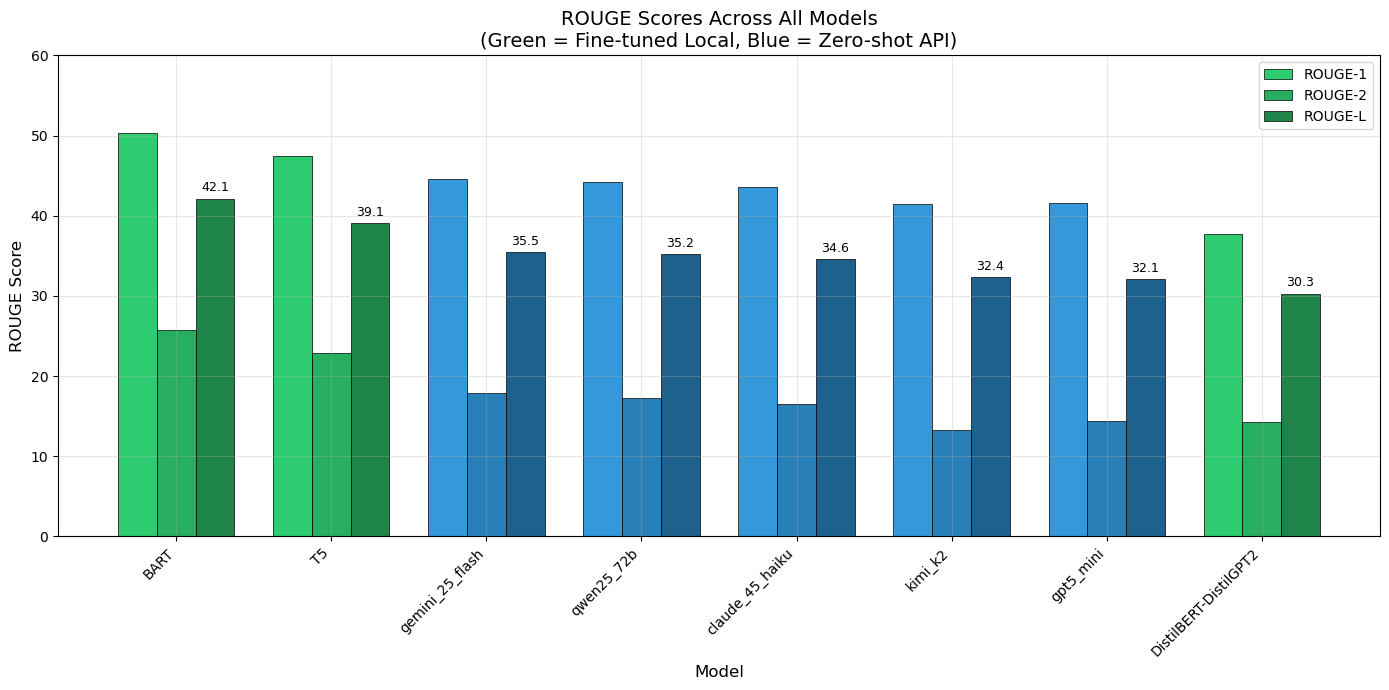

In [5]:
# ROUGE comparison bar chart
fig, ax = plt.subplots(figsize=(14, 7))

models = rouge_table['Model'].tolist()
x = np.arange(len(models))
width = 0.25

# Color by model type
colors_r1 = ['#2ecc71' if t == 'Fine-tuned local' else '#3498db' 
             for t in rouge_table['Type']]
colors_r2 = ['#27ae60' if t == 'Fine-tuned local' else '#2980b9' 
             for t in rouge_table['Type']]
colors_rL = ['#1e8449' if t == 'Fine-tuned local' else '#1f618d' 
             for t in rouge_table['Type']]

bars1 = ax.bar(x - width, rouge_table['ROUGE-1'], width, label='ROUGE-1', color=colors_r1, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, rouge_table['ROUGE-2'], width, label='ROUGE-2', color=colors_r2, edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, rouge_table['ROUGE-L'], width, label='ROUGE-L', color=colors_rL, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('ROUGE Score', fontsize=12)
ax.set_title('ROUGE Scores Across All Models\n(Green = Fine-tuned Local, Blue = Zero-shot API)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper right')
ax.set_ylim(0, 60)

# Add value labels on ROUGE-L bars
for bar in bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Interpreting the ROUGE Results

The results reveal a clear hierarchy:

**Tier 1: Purpose-built seq2seq models (BART, T5)**
- BART leads with 42.13 ROUGE-L, followed by T5 at 39.08
- These models were pretrained for generation tasks—their encoder-decoder attention was already well-calibrated

**Tier 2: Zero-shot frontier APIs (Gemini, Qwen, Claude)**
- Best performer is Gemini 2.5 Flash at 35.49 ROUGE-L
- Despite billions of parameters and trillions of training tokens, they fall 6.6 points below BART
- Qwen 2.5 72B (open-weight, cheapest) nearly matches Gemini—price doesn't predict quality

**Tier 3: Custom encoder-decoder and weaker APIs**
- DistilBERT→DistilGPT2 achieves 30.29 ROUGE-L—respectable but limited by architectural constraints
- GPT-5 Mini and Kimi K2 perform similarly (~32 ROUGE-L)

**Why don't frontier models win?**

The gap isn't about capability—it's about optimization target. API models are trained to be *helpful*, which often means being thorough, adding context, and explaining reasoning. SAMSum annotators wrote *terse* summaries. Fine-tuning teaches the exact style the reference expects; zero-shot prompting cannot.

### 3.4 Latency Comparison

In [6]:
# Load latency data from each experiment
def load_latency(path, model_name, model_type):
    """Load latency summary and add metadata."""
    df = pd.read_csv(path)
    df['type'] = model_type
    return df

# Fine-tuned models
exp1_latency = load_latency(
    MODELS_DIR / "bert-gpt2-distil" / "latency_summary.csv",
    "DistilBERT-DistilGPT2", "Fine-tuned local"
)
bart_latency = load_latency(
    MODELS_DIR / "bart" / "latency_summary.csv",
    "BART", "Fine-tuned local"
)
t5_latency = load_latency(
    MODELS_DIR / "t5" / "latency_summary.csv",
    "T5", "Fine-tuned local"
)

# API models
api_latency = pd.read_csv(MODELS_DIR / "api-frontier" / "latency_summary.csv")
api_latency['type'] = 'Zero-shot API'

# Combine all latency data
all_latency = pd.concat([
    bart_latency,
    t5_latency,
    exp1_latency,
    api_latency
], ignore_index=True)

# Sort by mean latency
all_latency = all_latency.sort_values('mean', ascending=True).reset_index(drop=True)

print("Latency data loaded for all models")

Latency data loaded for all models


In [7]:
# Create formatted latency table
latency_table = all_latency[['model', 'type', 'mean', 'p50', 'p95', 'max']].copy()
latency_table.columns = ['Model', 'Type', 'Mean (s)', 'P50 (s)', 'P95 (s)', 'Max (s)']

# Round for display
for col in ['Mean (s)', 'P50 (s)', 'P95 (s)', 'Max (s)']:
    latency_table[col] = latency_table[col].round(3)

print("="*80)
print("LATENCY — ALL MODELS (sorted by mean latency)")
print("="*80)
print()
display(latency_table)

# Key comparisons
fastest_local = latency_table[latency_table['Type'] == 'Fine-tuned local']['Mean (s)'].min()
fastest_api = latency_table[latency_table['Type'] == 'Zero-shot API']['Mean (s)'].min()

print(f"\nKey Finding:")
print(f"  Fastest fine-tuned model (BART): {fastest_local:.3f}s mean latency")
print(f"  Fastest API model (Gemini 2.5 Flash): {fastest_api:.3f}s mean latency")
print(f"  API models are {fastest_api/fastest_local:.1f}x slower on average")

LATENCY — ALL MODELS (sorted by mean latency)



,Model,Type,Mean (s),P50 (s),P95 (s),Max (s)
0,BART,Fine-tuned local,0.198,0.180,0.351,0.487
1,T5,Fine-tuned local,0.227,0.206,0.410,0.518
2,DistilBERT-DistilGPT2,Fine-tuned local,0.399,0.398,0.407,0.453
3,gemini_25_flash,Zero-shot API,0.648,0.617,0.809,2.647
4,gpt5_mini,Zero-shot API,1.200,1.132,1.643,5.809
5,claude_45_haiku,Zero-shot API,1.724,1.626,2.406,11.445
6,kimi_k2,Zero-shot API,2.199,1.179,6.343,11.416
7,qwen25_72b,Zero-shot API,2.946,2.166,8.087,14.889



Key Finding:
  Fastest fine-tuned model (BART): 0.198s mean latency
  Fastest API model (Gemini 2.5 Flash): 0.648s mean latency
  API models are 3.3x slower on average


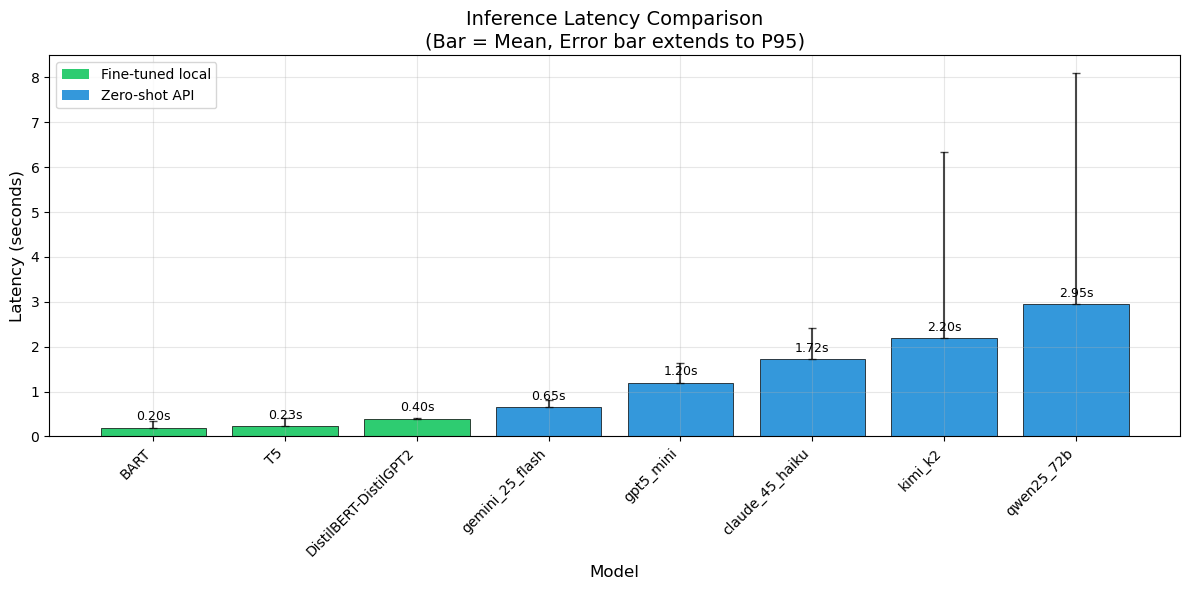

In [8]:
# Latency comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))

models = latency_table['Model'].tolist()
means = latency_table['Mean (s)'].tolist()
p95s = latency_table['P95 (s)'].tolist()
types = latency_table['Type'].tolist()

colors = ['#2ecc71' if t == 'Fine-tuned local' else '#3498db' for t in types]

x = np.arange(len(models))
bars = ax.bar(x, means, color=colors, edgecolor='black', linewidth=0.5)

# Add P95 error bars
ax.errorbar(x, means, yerr=[np.zeros(len(means)), [p95 - m for p95, m in zip(p95s, means)]], 
            fmt='none', color='black', capsize=3, capthick=1, alpha=0.7)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Latency (seconds)', fontsize=12)
ax.set_title('Inference Latency Comparison\n(Bar = Mean, Error bar extends to P95)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)

# Add value labels
for bar, mean in zip(bars, means):
    ax.annotate(f'{mean:.2f}s',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Fine-tuned local'),
                   Patch(facecolor='#3498db', label='Zero-shot API')]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

### Interpreting the Latency Results

**Local models are dramatically faster:**
- BART: 0.198s mean (fastest overall)
- T5: 0.227s mean
- Even the Frankenstein model: 0.399s mean

**API models have higher and more variable latency:**
- Gemini 2.5 Flash: 0.648s mean (fastest API), but P95 reaches 0.81s and max hits 2.6s
- Qwen 2.5 72B: 2.95s mean with P95 at 8.1s—significant tail latency
- Claude 4.5 Haiku and Kimi K2: Occasional requests exceed 11 seconds

**Why tail latency matters:**

In production, users experience the worst-case, not the average. If 5% of summaries take 6-8 seconds (Qwen P95), the product feels unreliable even though 95% are "fast enough." Local models have tight, predictable latency distributions—essential for real-time features.

### 3.5 Quality vs. Latency Trade-off

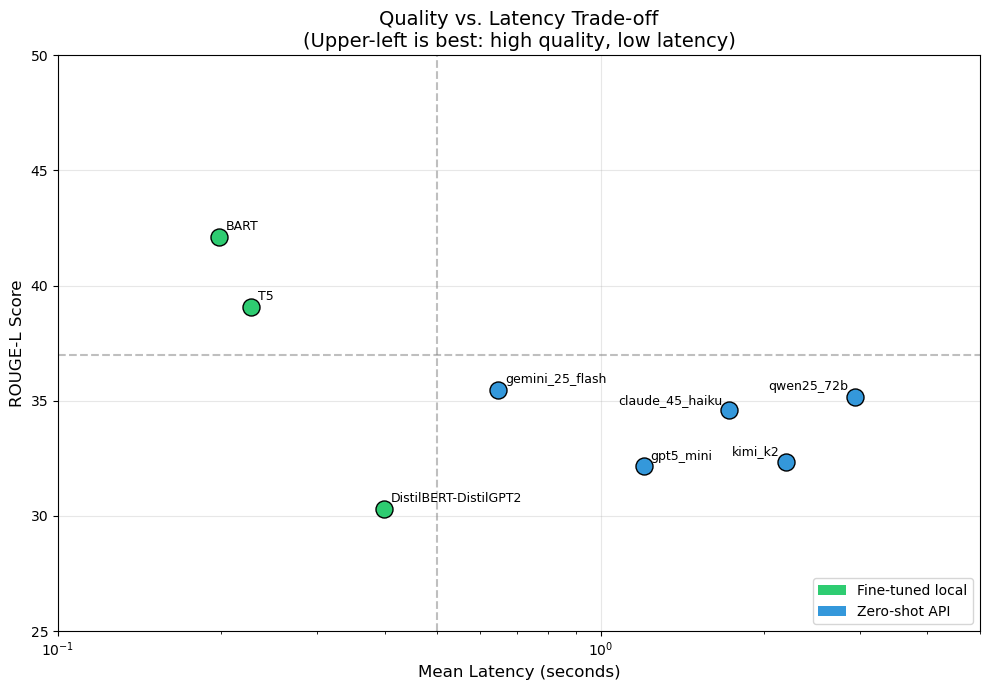

In [9]:
# Merge ROUGE and latency data for scatter plot
scatter_data = rouge_table.merge(
    latency_table[['Model', 'Mean (s)']], 
    on='Model'
)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot points
for idx, row in scatter_data.iterrows():
    color = '#2ecc71' if row['Type'] == 'Fine-tuned local' else '#3498db'
    ax.scatter(row['Mean (s)'], row['ROUGE-L'], 
               c=color, s=150, edgecolors='black', linewidth=1, zorder=5)
    
    # Label each point
    offset = (5, 5) if row['Mean (s)'] < 1.5 else (-5, 5)
    ha = 'left' if row['Mean (s)'] < 1.5 else 'right'
    ax.annotate(row['Model'], 
                xy=(row['Mean (s)'], row['ROUGE-L']),
                xytext=offset,
                textcoords='offset points',
                fontsize=9, ha=ha)

ax.set_xlabel('Mean Latency (seconds)', fontsize=12)
ax.set_ylabel('ROUGE-L Score', fontsize=12)
ax.set_title('Quality vs. Latency Trade-off\n(Upper-left is best: high quality, low latency)', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(0.1, 5)
ax.set_ylim(25, 50)

# Add legend
legend_elements = [Patch(facecolor='#2ecc71', label='Fine-tuned local'),
                   Patch(facecolor='#3498db', label='Zero-shot API')]
ax.legend(handles=legend_elements, loc='lower right')

# Add quadrant annotations
ax.axhline(y=37, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### The Pareto Frontier

The scatter plot makes the trade-off stark:

**BART occupies the ideal position:** Upper-left corner (high quality, low latency). No other model is both faster *and* better—BART is Pareto-optimal.

**T5 is a reasonable alternative:** Slightly slower and lower quality than BART, but still far ahead of API models on both dimensions.

**API models cluster in an awkward region:** Lower quality *and* higher latency than fine-tuned options. Their advantage lies elsewhere (convenience, no training required).

**The Frankenstein model:** Competitive on latency with APIs but lower quality than everything except GPT-5 Mini and Kimi K2. It demonstrates the architecture works, but not why you'd choose it.

## 4. Trade-Off Analysis: Choosing the Right Approach

Raw metrics don't make decisions—context does. This section frames the results through realistic deployment scenarios, each emphasizing different priorities.

### Scenario 1: Accuracy Above All Else

**Priority:** Maximize summary quality as measured by overlap with human references.

**Winner:** Fine-tuned BART

**Analysis:**
- BART achieves 42.13 ROUGE-L vs. 35.49 for the best API model (Gemini 2.5 Flash)
- The 6.64-point gap represents a 19% relative improvement
- Fine-tuning teaches the *exact* style SAMSum annotators expected
- API models are fluent but optimized for different objectives (helpfulness, safety, engagement)

**When to choose this:** Quality-critical applications where summaries influence downstream decisions (legal, medical, compliance).

### Scenario 2: Latency-Sensitive Applications

**Priority:** Real-time or near-real-time summarization (live meeting assistants, instant notifications, interactive search).

**Winner:** Fine-tuned local models (BART or T5)

**Analysis:**
- BART: 0.198s mean, 0.351s P95
- Best API model (Gemini Flash): 0.648s mean, but P95 reaches 0.81s and max hits 2.65s
- Tail latency matters for UX—users notice when 1 in 20 requests takes 3+ seconds
- Local models have tight, predictable latency distributions

**When to choose this:** Any feature where users wait for the summary (hover previews, inline suggestions, real-time transcription).

### Scenario 3: Budget-Constrained / High-Volume

**Priority:** Minimize cost at scale (millions of conversations per month).

**Winner:** Fine-tuned local models (overwhelmingly)

In [10]:
# Cost projection for API models at 1M conversations/month
# Assumptions: ~150 tokens input, ~40 tokens output per conversation

cost_data = {
    'Model': ['Fine-tuned BART', 'Fine-tuned T5', 'Qwen 2.5 72B', 'GPT-5 Mini', 
              'Gemini 2.5 Flash', 'Kimi K2', 'Claude 4.5 Haiku'],
    'Input $/M tokens': [0, 0, 0.07, 0.25, 0.30, 0.39, 1.00],
    'Output $/M tokens': [0, 0, 0.26, 2.00, 2.50, 1.90, 5.00],
    'Type': ['Local', 'Local', 'API', 'API', 'API', 'API', 'API']
}

cost_df = pd.DataFrame(cost_data)

# Calculate monthly cost at 1M conversations
tokens_in = 150 * 1_000_000 / 1_000_000  # Million tokens
tokens_out = 40 * 1_000_000 / 1_000_000

cost_df['Monthly Cost @ 1M convos'] = (
    cost_df['Input $/M tokens'] * tokens_in + 
    cost_df['Output $/M tokens'] * tokens_out
)

# Format for display
cost_df['Monthly Cost @ 1M convos'] = cost_df['Monthly Cost @ 1M convos'].apply(
    lambda x: f"${x:.2f}" if x > 0 else "~$0 (compute only)"
)

print("="*80)
print("COST PROJECTION — 1 MILLION CONVERSATIONS PER MONTH")
print("="*80)
print("Assumptions: 150 tokens input, 40 tokens output per conversation")
print()
display(cost_df[['Model', 'Type', 'Monthly Cost @ 1M convos']])

COST PROJECTION — 1 MILLION CONVERSATIONS PER MONTH
Assumptions: 150 tokens input, 40 tokens output per conversation



,Model,Type,Monthly Cost @ 1M convos
0,Fine-tuned BART,Local,~$0 (compute only)
1,Fine-tuned T5,Local,~$0 (compute only)
2,Qwen 2.5 72B,API,$20.90
3,GPT-5 Mini,API,$117.50
4,Gemini 2.5 Flash,API,$145.00
5,Kimi K2,API,$134.50
6,Claude 4.5 Haiku,API,$350.00


**Analysis:**
- Fine-tuned models: ~$0/month after one-time training (~$10-50 in GPU compute)
- Cheapest API (Qwen): ~$21/month
- Most expensive API (Claude): ~$350/month

At 10M conversations/month:
- Qwen: ~$210/month, ~$2,520/year
- Claude: ~$3,500/month, ~$42,000/year
- Local: Still ~$0 (plus electricity and hardware amortization)

The break-even point is tiny—after a few thousand conversations, fine-tuning pays for itself.

**When to choose this:** Any production deployment at meaningful scale.

### Scenario 4: Rapid Prototyping / Time-to-Market

**Priority:** Ship something today, optimize later.

**Winner:** Zero-shot API models

**Analysis:**
- API models require zero training—just prompt design
- Can prototype in hours instead of days
- Good for validating the product concept before investing in fine-tuning
- Gemini 2.5 Flash or Qwen 2.5 72B offer the best quality/cost balance for prototyping

**Recommendation:** Start with APIs, collect user feedback on summary quality and style, then migrate to fine-tuned models as volume grows.

**When to choose this:** Early-stage products, hackathons, proof-of-concept demos.

### Scenario 5: Privacy and Data Sovereignty

**Priority:** Keep all data on-premises; comply with strict data handling policies.

**Winner:** Fine-tuned local models (the only option)

**Analysis:**
- API calls send raw conversation text to third-party servers
- In regulated industries (finance, healthcare, government), this may be prohibited
- GDPR, HIPAA, and similar regulations impose data residency requirements
- Fine-tuned models run entirely on your infrastructure—data never leaves

**When to choose this:** Any context where conversation content is sensitive (employee chats, customer support, legal discussions).

### Scenario 6: Operational Simplicity

**Priority:** Minimize infrastructure complexity and maintenance burden.

**Winner:** Depends on scale

**Analysis:**

| Volume | Recommended Approach | Reasoning |
|--------|---------------------|------------|
| <10K/month | API models | No GPUs to manage, no model deployment, automatic scaling |
| 10K–100K/month | Either | Depends on team capabilities and cost sensitivity |
| >100K/month | Local models | Amortized infrastructure cost beats per-call pricing |

API providers handle:
- Scaling and load balancing
- Model updates and improvements
- Redundancy and failover

Local deployment requires:
- GPU infrastructure (or CPU inference with higher latency)
- Containerization and orchestration
- Monitoring and alerting
- Model versioning and rollback

**When to choose APIs:** Small teams without ML infrastructure expertise.

**When to choose local:** Teams with existing MLOps capabilities or willingness to build them.

### Scenario 7: Summary Style Preference

**Priority:** Get the "right" summary style for your use case.

**Winner:** Depends on what you want

**Analysis:**

| If you want... | Choose... |
|----------------|----------|
| SAMSum-style (terse, outcome-focused, ~20 words) | Fine-tuned BART |
| More context and narrative (who said what, why) | API models |
| Custom style specific to your domain | Fine-tune on your own data |

The qualitative examples (Section 5) show that API models often include more detail—this isn't *wrong*, it's *different*. Some users prefer elaboration; others want brevity.

**Key insight:** If your desired style differs from SAMSum, fine-tuning on SAMSum may not be appropriate anyway. You'd need domain-specific training data.

### Scenario 8: Reliability and Predictability

**Priority:** Consistent behavior across all requests; no surprises.

**Winner:** Fine-tuned local models

**Analysis:**
- Local models: Deterministic (same input → same output with temperature=0), no external dependencies
- API models: Subject to provider outages, rate limits, and behavior changes
- Qwen 2.5 72B had 30 failures (3.7%) in our evaluation—not catastrophic, but notable
- Claude and GPT-5 Mini had zero failures, but latency varied significantly

**When to choose this:** Mission-critical applications where failures have consequences.

## 5. The Frankenstein Model — A Postmortem

Experiment 1 deserves honest reflection. The DistilBERT→DistilGPT2 architecture achieved 30.29 ROUGE-L—competitive with GPT-5 Mini and Kimi K2, but far below BART. This isn't a failure of implementation; it's an architectural limitation worth understanding.

In [11]:
# Training dynamics comparison
training_comparison = pd.DataFrame({
    'Model': ['BART', 'T5', 'DistilBERT→DistilGPT2'],
    'Epochs to Converge': [4, 9, 10],
    'Best Val ROUGE-L': [43.51, 41.05, 31.09],
    'Final Test ROUGE-L': [42.13, 39.08, 30.29],
    'Training Time (min)': [33, 52, 57]
})

print("Training Dynamics Comparison")
print("="*60)
display(training_comparison)

Training Dynamics Comparison


,Model,Epochs to Converge,Best Val ROUGE-L,Final Test ROUGE-L,Training Time (min)
0,BART,4,43.51,42.13,33
1,T5,9,41.05,39.08,52
2,DistilBERT→DistilGPT2,10,31.09,30.29,57


### Why the Gap?

The fundamental issue: **DistilBERT and DistilGPT2 were never trained to communicate.**

- BERT is a bidirectional encoder pretrained with masked language modeling
- GPT-2 is an autoregressive decoder pretrained with next-token prediction
- When combined via `EncoderDecoderModel`, the cross-attention layers start **randomly initialized**

This means the model must learn *how to translate between representation spaces* using only SAMSum's 14,731 training examples. That's a lot to ask.

BART and T5, by contrast, were pretrained as complete encoder-decoder systems. Their cross-attention was trained on billions of tokens before we ever loaded SAMSum. The encoder and decoder already know how to talk to each other.

### Qualitative Error Patterns

The Frankenstein model's failures were distinctive:

**Example 1 (Test ID 86 — New Year's Eve Planning):**
- **Human:** "Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho."
- **Frankenstein:** "Olaf is planning to go to the New Year's Eve party, but he's not sure if it's worth the money. Poppy and Nathan will go to Mobtong."

The model hallucinates names ("Poppy", "Nathan", "Mobtong") and misses the actual decision.

**Example 2 (Test ID 678 — Marzipan Cake):**
- **Human:** "Kate and Jeff are downstairs in a room next to the reception. Some lady is making a marzipan cake."
- **Frankenstein:** "Kate is waiting for a cake she made in the reception next to the reception. Kate saw a man making a penis out of a panda. He made a penis out of a panda."

Repetition, gender confusion, and bizarre hallucinations.

### The Lesson

Meeting assignment requirements ("BERT encoder + autoregressive decoder") is not the same as building an effective system. The experiment demonstrates *why* purpose-built seq2seq models exist—and why practitioners reach for BART/T5 instead of assembling components.

That said, 30.29 ROUGE-L is not useless. It's competitive with some frontier models and proves the architecture *can* work. With more training data or a larger model, results would likely improve. The approach isn't wrong—it's just less efficient than using purpose-built alternatives.

## 6. What ROUGE Doesn't Tell You

The metrics favor fine-tuned models, but qualitative review reveals a more nuanced picture. Sometimes the "worse" ROUGE score corresponds to a *better* summary.

### Example 1: When Verbosity Helps

**Test ID 432 — Tattoo Parlor Discussion**

| Source | Summary |
|--------|--------|
| **Human Reference** | "Javier was initially eager to have a tattoo done at Warsaw Ink but the price turned out to be too high. Javier decided to have a tattoo done in Colombia." |
| **BART** | "Javier will get a Warsaw ink tattoo back in colombia." |
| **Gemini 2.5 Flash** | "Javier asked Judie for English-speaking tattoo parlor recommendations. Judie suggested Warsaw Ink, but Javier decided against it due to the high price." |
| **GPT-5 Mini** | "Javier asks for English-speaking tattoo parlors; Judie recommends Warsaw Ink and says her girlfriend got a tattoo there for $1000, so Javier decides to get tattooed in Colombia instead." |

**Analysis:**
- BART is concise but slightly misleading ("will get a Warsaw ink tattoo" implies he's getting it *at* Warsaw Ink)
- Gemini captures the decision correctly but drops the Colombia detail
- GPT-5 Mini includes the crucial price point ($1000) that *explains* the decision

GPT-5 Mini's summary is arguably the most useful—but ROUGE penalizes it for extra words that don't appear in the reference.

### Example 2: When BART Misses the Point

**Test ID 417 — Cancelled Meeting**

| Source | Summary |
|--------|--------|
| **Human Reference** | "Miranda can't make her meeting with Stephanie as she has to work." |
| **BART** | "Miranda has to work 20 hours a day." |
| **Claude 4.5 Haiku** | "Miranda requests to cancel tomorrow's meeting due to work obligations. Stephanie agrees after Miranda explains her demanding schedule as a young doctor." |
| **Kimi K2** | "Miranda canceled tomorrow's meeting due to work; Stephanie accepted after some teasing about doctors' grueling hours." |

**Analysis:**
- BART focuses on a detail ("20 hours") while missing the actual outcome (meeting cancelled)
- Claude and Kimi K2 both capture the cancellation *and* Stephanie's response
- The frontier models understand the conversation's purpose better

This is a case where ROUGE-L scores don't reflect semantic accuracy. BART gets partial n-gram overlap but misses the point entirely.

### Example 3: Different Styles, Both Valid

**Test ID 86 — New Year's Eve Planning**

| Source | Summary |
|--------|--------|
| **Human Reference** | "Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho." |
| **BART** | "Olafur and Nathalie will go to Tiffany's party for New Year's Eve." |
| **Gemini 2.5 Flash** | "The group decided to go to a club in Soho for New Year's Eve, after considering opera and a 'Breakfast at Tiffany's' party. They need to buy tickets soon." |
| **Kimi K2** | "Group agrees on a 'classy' New Year's Eve: they'll buy tickets for the Breakfast-at-Tiffany's-themed party at Soho club." |

**Analysis:**
- BART is concise but drops Zoe and the decision-making process
- Gemini and Kimi K2 preserve more context (the opera consideration, the "classy" requirement)
- Which is "better" depends on what you want from a summary

If you want action items: BART is fine.
If you want to understand *why* the decision was made: frontier models are better.

### The Takeaway

ROUGE measures lexical overlap with a single reference. It cannot evaluate:
- **Semantic accuracy:** Does the summary mean the right thing?
- **Completeness:** Are key details included?
- **User preference:** Would a human choose this summary over another?

Fine-tuned models score higher because they learn to mimic SAMSum annotators' style. API models score lower because they're optimized for different objectives—but they're not *wrong*. They're just different.

For production deployment, human evaluation or task-specific metrics (e.g., "Did the summary capture the decision?") would be essential. ROUGE is a useful starting point, not the final word.

## 7. Recommendations

Based on the consolidated analysis, here are concrete recommendations for different contexts.

### For a Messaging Platform Starting from Scratch

1. **Prototype with Gemini 2.5 Flash or Qwen 2.5 72B**
   - Best quality/cost among API options
   - Get a working feature in front of users quickly

2. **Collect user feedback on summary quality and style preferences**
   - Do users want terse outcomes or contextual narratives?
   - What information do they actually need?

3. **If volume exceeds ~50K conversations/month, begin fine-tuning BART**
   - The cost savings alone justify the investment
   - Better metrics are a bonus

4. **Deploy fine-tuned models locally for production**
   - Faster, cheaper, private, more reliable

5. **Keep API option available as fallback**
   - During model updates or traffic spikes
   - For A/B testing new summary styles

### For Teams with Existing Fine-Tuning Infrastructure

1. **Start with BART directly**
   - Skip the API prototyping phase
   - You already have the capabilities to train and deploy

2. **Consider T5 if you need multi-task capability**
   - T5's text-to-text framework handles diverse tasks with a single model
   - Useful if you also need classification, extraction, or Q&A

3. **Use API models for experimentation**
   - A/B test different summary styles with users
   - Benchmark new frontier models as they're released

4. **Fine-tune on your own domain data if possible**
   - SAMSum is messenger-style conversations; your data may differ
   - Domain-specific fine-tuning typically outperforms generic models

### What NOT to Do

1. **Don't build a custom encoder-decoder from mismatched components unless you have a specific research reason**
   - Experiment 1 proved it *can* work, but purpose-built models are simply better
   - The engineering effort isn't justified for practical applications

2. **Don't assume frontier models are automatically better**
   - Bigger ≠ better for domain-specific tasks
   - Fine-tuning on 15K examples beats trillion-parameter zero-shot

3. **Don't ignore tail latency for interactive features**
   - Mean latency is misleading if P95 is 5× higher
   - Users experience the worst case, not the average

4. **Don't deploy API-dependent features without fallback plans**
   - Providers have outages, rate limits, and pricing changes
   - Build abstraction layers that support multiple backends

## 8. Limitations and Future Work

No study is complete without acknowledging what it doesn't cover.

### Limitations of This Study

**Dataset constraints:**
- Single dataset (SAMSum)—results may not generalize to other dialogue domains (customer support, technical discussions, multilingual conversations)
- SAMSum is English-only; many messaging platforms serve global, multilingual users
- Mostly two-person conversations; real group chats have more complex dynamics

**Computational constraints:**
- Consumer GPU training (16GB VRAM)—larger models (BART-large, T5-base, Flan-T5) might perform better
- Limited hyperparameter search due to time constraints

**Evaluation constraints:**
- API evaluation on a single run—latency varies by time of day, geography, and provider load
- No human evaluation—ROUGE is an imperfect proxy for actual usefulness
- No task-specific metrics (e.g., "Did the summary capture the decision?")

**Scope constraints:**
- Did not investigate running open-source LLMs locally (e.g., Phi-3, Gemma-2, Mistral 7B, Llama 3 8B quantized)
- These models might offer a different trade-off: near-API quality with local deployment benefits
- This was out of scope due to time constraints but represents a clear avenue for future work

### Future Work Directions

**Immediate extensions:**
- Evaluate local open-source LLMs (Phi-3-mini, Gemma-2-2b, Mistral-7B-Instruct quantized to fit 16GB)
- Fine-tune on domain-specific data (e.g., actual customer support transcripts, Slack exports)
- Conduct human evaluation with task-specific rubrics

**Production considerations:**
- Test retrieval-augmented approaches for long conversation histories
- Explore streaming summarization (update summaries incrementally as messages arrive)
- Benchmark on-device models for mobile deployment (Phi-3-mini, Gemma-2)

**Research directions:**
- Investigate controllable summarization (user-specified length, focus, detail level)
- Explore multi-document summarization for channel-level overviews
- Study how summary quality degrades with conversation length and complexity

**Evaluation improvements:**
- Develop task-specific metrics beyond ROUGE (decision capture, action item extraction)
- A/B test different summary styles with real users
- Measure downstream task performance (e.g., do summaries help users respond faster?)

## 9. Final Thoughts

We set out to answer a practical question: *How should a messaging platform approach automated conversation summarization?*

The answer is nuanced but clear:

**Fine-tuned BART delivers the best automatic metrics at the lowest cost and latency.** For production deployment at scale, it's the obvious choice. The 6.6 ROUGE-L point advantage over frontier APIs, combined with 3× faster inference and zero marginal cost, makes the case compelling.

**But "best" depends on what you're optimizing for.** API models offer convenience, zero training investment, and a different (arguably more informative) summary style. For prototyping, low-volume use cases, or teams without ML infrastructure, they're perfectly reasonable.

**The Frankenstein architecture proved the concept but not the value.** Gluing BERT and GPT-2 together works—30 ROUGE-L isn't nothing—but purpose-built alternatives are simply better. The experiment demonstrates *why* models like BART and T5 exist.

**ROUGE isn't the whole story.** The qualitative examples reveal that API models sometimes produce *better* summaries that score *worse* because they're more verbose or use different phrasing. For production, human evaluation or task-specific metrics would be essential.

The real insight isn't which model "won." It's understanding the trade-offs well enough to make informed decisions:

| If you prioritize... | Choose... |
|---------------------|----------|
| ROUGE scores | Fine-tuned BART |
| Latency | Fine-tuned BART or T5 |
| Cost at scale | Fine-tuned local models |
| Time-to-market | Zero-shot API models |
| Privacy | Fine-tuned local models |
| Operational simplicity (low volume) | API models |
| Contextual/narrative summaries | API models |

Dialogue summarization is a solved-enough problem that production deployment is feasible today. The choice between approaches is operational, not technical. The models work. The question is which trade-offs fit your context.

---

*This project was completed as part of the Flatiron School AI/ML program, November-December 2025.*